# Study 1


In [ ]:
import pandas as pd

# Load the dataset
data_study1 = pd.read_csv("Study1new.csv")

# Remove the first two rows
data_study1 = data_study1.iloc[2:, :]

# Convert 'year_birth' to numeric
data_study1['year_birth'] = pd.to_numeric(data_study1['year_birth'], errors='coerce')
data_study1['age'] = pd.to_numeric(data_study1['age'], errors='coerce')
data_study1['stop_disp'] = pd.to_numeric(data_study1['stop_disp'], errors='coerce')
data_study1['check_last_dim'] = pd.to_numeric(data_study1['check_last_dim'], errors='coerce')
data_study1['Ment _9'] = pd.to_numeric(data_study1['Ment _9'], errors='coerce')

# Calculate age2 based on birth year
data_study1['age2'] = 2024 - data_study1['year_birth']

# Filter the data based on age and other conditions
# Filter the data based on age and other conditions
data_study1_filtered = data_study1[
    ((data_study1['age'] == data_study1['age2']) |
     (data_study1['age'] == data_study1['age2'] - 1) |
     (data_study1['age'] == data_study1['age2'] + 1)) &
    (data_study1['stop_disp'] == 2) &
    (data_study1['check_last_dim'] == 1) &
    (data_study1['Ment _9'] == 1)
]

# Save the filtered data to a new CSV file
data_study1_filtered.to_csv("Study1_results_filtered.csv")


In [2]:
import pandas as pd
import numpy as np
mturk = pd.read_csv("/content/Study1_results_filtered.csv")
mturk = mturk[mturk["Duration (in seconds)"]>500]
# list(mturk.columns)
k = lambda x: tuple(x.split(":")[0].replace(".png","").split("_"))
v = lambda x: float(x.split(":")[1] if x.split(":")[1]!="undefined" else -1)
ratings = []
std = []
import matplotlib.pyplot as plt
for i,r in enumerate(mturk["ratings_list"].to_list()):
  order = []
  for x in r.split(","):
    if x not in order and x.split(":")[0].replace(".png",""):
      order+=[x]
  rating = [mturk.loc[:,c].iloc[i] for c in [m for m in mturk.columns if "_Q" in m]]

  r = [k(filename)+(str(k(filename)),impression) for filename,impression in zip(order,rating)]
  std+=[np.std([float(rr[-1]) for rr in r])]
  if std[-1]>1 or True:
    ratings += r

mturk2 = pd.DataFrame(ratings).iloc[:,-2:]
means = mturk2.groupby(3).mean().reset_index()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Study1_results_filtered.csv'

In [ ]:
import pandas as pd
import ast

# Assuming the data is in a DataFrame called 'df'
# If it's not, you'll need to load it first
df = means.copy()
df.columns = ['features', 'rating']
# Step 1: Split the 'features' column into separate columns
df[['image', 'attribute', 'value']] = df['features'].apply(ast.literal_eval).tolist()
df.value = df.value.apply(lambda x: x.replace('24.76','1').replace('39.99','1').replace('27.91','1').replace('25.00','1').replace('30.28','1').replace('38.02','1').replace('2','1').replace('3','1').replace('.00',''))
# Step 2: Pivot the DataFrame to create columns for each 'value'
df_pivot = df.pivot(index=['image', 'attribute'], columns='value', values='rating')

# Step 3: Reset the index to make 'image' and 'attribute' regular columns
df_pivot.reset_index(inplace=True)

# Step 4: Rename the columns for clarity
df_pivot.columns.name = None
df_pivot.rename(columns={"-1": 'Decreased trait intensity', "0": 'Neutral condition', "1": 'Increased trait intensity'}, inplace=True)

# Step 5: Sort the DataFrame by 'image' and 'attribute' for better readability
df_pivot.sort_values(['image', 'attribute'], inplace=True)

# Display the result
# print(df_pivot[df_pivot.attribute == "dominant"])
for r in df_pivot.attribute.unique():
  print(r)
  display(df_pivot[df_pivot.attribute == r].drop(["image","attribute"], axis=1).mean())

black


,0
Decreased trait intensity,54.900462
-10norm1.059,NaN
-10norm1.071,NaN
-10norm1.110,NaN
-10norm1.146,NaN
...,...
15norm6.887,NaN
15norm6.947,NaN
15norm6.955,NaN
15norm7.018,NaN


dominant


,0
Decreased trait intensity,NaN
-10norm1.059,46.375000
-10norm1.071,46.966875
-10norm1.110,NaN
-10norm1.146,54.380000
...,...
15norm6.887,74.052105
15norm6.947,60.474000
15norm6.955,58.517500
15norm7.018,70.485789


happy


,0
Decreased trait intensity,40.126195
-10norm1.059,NaN
-10norm1.071,NaN
-10norm1.110,NaN
-10norm1.146,NaN
...,...
15norm6.887,NaN
15norm6.947,NaN
15norm6.955,NaN
15norm7.018,NaN


trustworthy


,0
Decreased trait intensity,NaN
-10norm1.059,NaN
-10norm1.071,NaN
-10norm1.110,62.320526
-10norm1.146,NaN
...,...
15norm6.887,NaN
15norm6.947,NaN
15norm6.955,NaN
15norm7.018,NaN


In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from math import sqrt

# Assuming df is your dataframe and is already defined
# The df should have columns 'attribute', 'value', 'rating', 'gender', and 'age' if available

# Create a dictionary to store the ANOVA and Tukey results for each attribute
anova_results = {}
tukey_results = {}
effect_sizes = {}  # Store Cohen's d for post-hoc comparisons
summary_statistics = {}  # Store means and SDs
# Step 1: Calculate participant statistics
total_participants = mturk['gender'].count()

# Calculate counts and percentages for each gender code
gender_counts = mturk['gender'].value_counts()
gender_percentages = (gender_counts / total_participants) * 100

# Print total participants and gender statistics
print(f"A total of {total_participants} participants were recruited.")

# Print the counts and percentages for each gender code
for gender_code, count in gender_counts.items():
    percentage = gender_percentages[gender_code]
    print(f"Gender code {gender_code}: {count} participants ({percentage:.2f}%)")

# Step 2: Calculate and display the mean and standard deviation of age
mean_age = mturk['age'].mean()
std_age = mturk['age'].std()
print(f"\nMage = {mean_age:.2f}, SDage = {std_age:.2f}")

# Step 2: Loop through each unique attribute and perform ANOVA and post-hoc tests
for attribute in df['attribute'].unique():
    # Subset the dataframe for the current attribute
    subset_df = df[df['attribute'] == attribute]

    # Perform one-way ANOVA
    model = ols('rating ~ C(value)', data=subset_df).fit()
    anova_table = anova_lm(model, typ=2)

    # Store ANOVA result
    anova_results[attribute] = anova_table

    # Compute eta squared (η²) for effect size
    ss_total = anova_table['sum_sq'].sum()  # total sum of squares
    eta_squared = anova_table['sum_sq'][0] / ss_total  # eta² for the main effect
    anova_results[attribute]['eta_squared'] = eta_squared

    # Perform Tukey's HSD post-hoc comparisons
    tukey = pairwise_tukeyhsd(endog=subset_df['rating'], groups=subset_df['value'], alpha=0.05)
    tukey_results[attribute] = tukey

    # Calculate summary statistics for the means and SDs for each condition
    summary_stats = subset_df.groupby('value')['rating'].agg(['mean', 'std']).reset_index()
    summary_statistics[attribute] = summary_stats

    # Calculate Cohen's d for each post-hoc comparison in Tukey's HSD
    comparisons = tukey._results_table.data[1:]  # Extract comparisons from Tukey's HSD table
    d_values = []

    for comparison in comparisons:
        group1, group2, mean_diff, p_value, lower, upper, reject = comparison

        # Calculate pooled standard deviation for Cohen's d
        sd1 = summary_stats[summary_stats['value'] == group1]['std'].values[0]
        sd2 = summary_stats[summary_stats['value'] == group2]['std'].values[0]
        n1 = subset_df[subset_df['value'] == group1]['rating'].count()
        n2 = subset_df[subset_df['value'] == group2]['rating'].count()
        pooled_sd = sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))

        # Calculate Cohen's d
        d_value = mean_diff / pooled_sd
        d_values.append((group1, group2, d_value))

    # Store Cohen's d values for this attribute
    effect_sizes[attribute] = d_values

# Step 3: Display the results

for attribute in anova_results:
    # Display ANOVA results
    print(f"\nANOVA result for {attribute}:")
    print(anova_results[attribute])

    # Display post-hoc results
    print(f"\nTukey HSD result for {attribute}:")
    print(tukey_results[attribute])

    # Display means, SDs, and Cohen's d for each comparison
    print(f"\nSummary statistics for {attribute}:")
    print(summary_statistics[attribute])

    print(f"\nEffect sizes (Cohen's d) for {attribute}:")
    for comparison in effect_sizes[attribute]:
        print(f"Comparison between {comparison[0]} and {comparison[1]}: Cohen's d = {comparison[2]:.4f}")



A total of 60 participants were recruited.
After excluding participants, our final sample consisted of 60 participants.

Gender code 1: 38 participants (63.33%)
Gender code 2: 21 participants (35.00%)
Gender code 3: 1 participants (1.67%)

Mage = 27.77, SDage = 4.54


<ipython-input-31-9f3d8e0af99e>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = anova_table['sum_sq'][0] / ss_total  # eta² for the main effect
<ipython-input-31-9f3d8e0af99e>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = anova_table['sum_sq'][0] / ss_total  # eta² for the main effect
<ipython-input-31-9f3d8e0af99e>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = anova_table['sum_sq'


ANOVA result for age:
               sum_sq    df          F    PR(>F)  eta_squared
C(value)  1761.360166   2.0  15.699727  0.000008     0.427789
Residual  2356.000414  42.0        NaN       NaN     0.427789

Tukey HSD result for age:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    -1      0    6.024 0.0824 -0.6202 12.6683  False
    -1      1  15.2153    0.0   8.571 21.8596   True
     0      1   9.1912 0.0046  2.5469 15.8355   True
----------------------------------------------------

Summary statistics for age:
  value       mean       std
0    -1  35.120671  6.464531
1     0  41.144719  7.234082
2     1  50.335939  8.611832

Effect sizes (Cohen's d) for age:
Comparison between -1 and 0: Cohen's d = 0.8781
Comparison between -1 and 1: Cohen's d = 1.9983
Comparison between 0 and 1: Cohen's d = 1.1557

ANOVA result for dominant:
               sum_sq    df         F    P

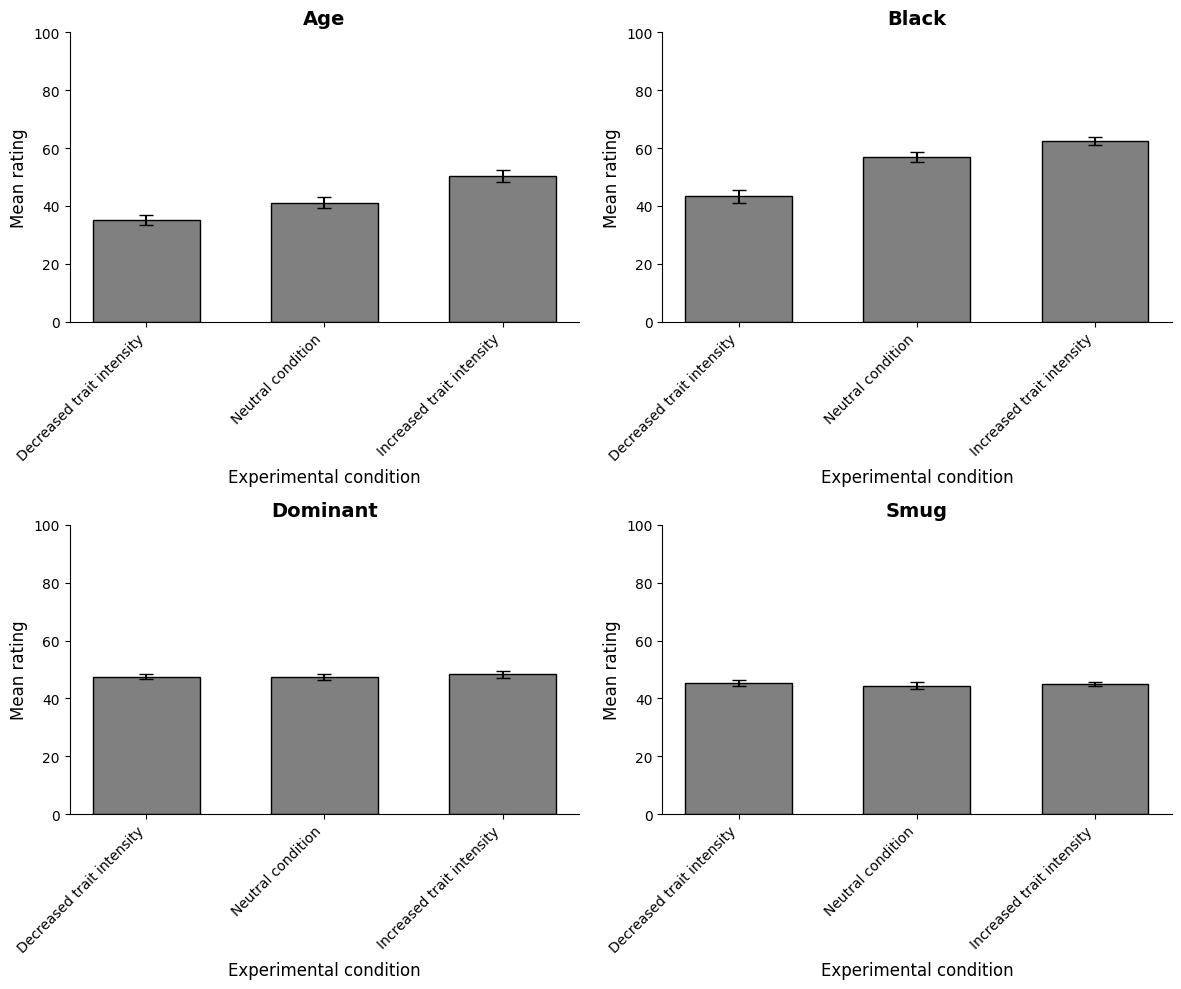

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataframe df is already defined and processed

# Step 1: Calculate the mean and standard error for each condition and attribute
summary_df = df.groupby(['attribute', 'value']).agg(
    mean_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    count=('rating', 'size')
).reset_index()

# Step 2: Calculate the standard error of the mean (SEM)
summary_df['sem'] = summary_df['std_rating'] / np.sqrt(summary_df['count'])

# Step 3: Plotting the data for each attribute with confidence intervals
attributes = summary_df['attribute'].unique()
conditions = ['Decreased trait intensity', 'Neutral condition', 'Increased trait intensity']

# Function to create bar plot with confidence intervals
def plot_with_confidence_intervals(attribute, ax):
    subset = summary_df[summary_df['attribute'] == attribute]

    # Define positions for bars
    bar_positions = np.arange(len(conditions))

    # Create bars with error bars
    ax.bar(
        bar_positions,
        subset['mean_rating'],
        yerr=subset['sem'],
        capsize=5,
        color='gray',   # Bar color
        edgecolor='black',  # Edge color for clearer borders
        ecolor='black',  # Color for the error bars
        error_kw={'elinewidth': 1.5},  # Error bar line width
        width=0.6  # Width of bars
    )

    # Set x-ticks to the conditions
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(conditions, rotation=45, ha='right')
    ax.set_ylim(0, 100)  # Adjust y-axis dynamically
    # Set title and axis labels
    ax.set_title(attribute.capitalize(), fontsize=14, weight='bold')  # Clear and bold titles
    ax.set_xlabel('Experimental condition', fontsize=12)
    ax.set_ylabel('Mean rating', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Customize tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Remove the top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Step 4: Create subplots for all attributes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate over each attribute and plot on a separate subplot
for i, attribute in enumerate(attributes):
    ax = axes.flatten()[i]
    plot_with_confidence_intervals(attribute, ax)

# Set consistent layout
plt.tight_layout()

# Save the figure to ensure publication quality (e.g., DPI of 300)
plt.savefig("attribute_confidence_intervals_bars.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Study 2

## Means

In [ ]:
import pandas as pd

# Load the CSV file
data_study2a = pd.read_csv("TEST+TWARZY+POLSKA+WERSJA_October+31,+2024_20.44.csv")

# Remove the first two rows
data_study2a = data_study2a.iloc[2:, :]

data_study2a['stop_disp'] = pd.to_numeric(data_study2a['stop_disp'], errors='coerce')
data_study2a['check_last_dim'] = pd.to_numeric(data_study2a['check_last_dim'], errors='coerce')
# Filter the DataFrame where stop_disp is 2 and check_last_dim is 1
data_study2a_filtered = data_study2a[(data_study2a['stop_disp'] == 2) & (data_study2a['check_last_dim'] == 1)]

# Save the filtered data to a new CSV file
data_study2a_filtered.to_csv("Study2a_filtered.csv", index=False)

# Count occurrences of each unique value in the 'particip' column
particip_count = data_study2a_filtered['particip'].value_counts()
print(particip_count)


<ipython-input-2-7d54341496ff>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_study2a['stop_disp'] = pd.to_numeric(data_study2a['stop_disp'], errors='coerce')
<ipython-input-2-7d54341496ff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_study2a['check_last_dim'] = pd.to_numeric(data_study2a['check_last_dim'], errors='coerce')


particip
2    25
0    23
1    21
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
means = pd.read_csv("/content/Study2a_filtered.csv")
means = means[means["Duration (in seconds)"]>500]
# list(mturk.columns)
k = lambda x: tuple(x.split(":")[0].split("norm")[0].replace(".png","").split("_"))
v = lambda x: float(x.split(":")[1] if x.split(":")[1]!="undefined" else -1)
ratings = []
std = []
import matplotlib.pyplot as plt
for i,r in enumerate(means["ratings_list"].to_list()):
  order = []
  for x in r.split(","):
    if x not in order and x.split(":")[0].replace(".png",""):
      order+=[x]
  rating = [means.loc[:,c].iloc[i] for c in [m for m in means.columns if "_Q" in m]]

  r = [k(filename)+(str(k(filename)),impression) for filename,impression in zip(order,rating)]
  std+=[np.std([float(rr[-1]) for rr in r])]
  if std[-1]>1 or True:
    ratings += r

means2 = pd.DataFrame(ratings).iloc[:,-2:]
means_means = means2.groupby(3).mean().reset_index()


In [ ]:
import pandas as pd
import ast

# Assuming the data is in a DataFrame called 'df'
# If it's not, you'll need to load it first
df_a = means_means.copy()
df_a.columns = ['features', 'rating']
# Step 1: Split the 'features' column into separate columns
df_a[['image', 'attribute', 'value']] = df_a['features'].apply(ast.literal_eval).tolist()
df_a.value = df_a.value.apply(lambda x: x.replace('24.76','1').replace('25.00','1').replace('20.00','1').replace('35.00','1').replace('30.28','1').replace('38.02','1'))
# Step 2: Pivot the DataFrame to create columns for each 'value'
df_a_pivot = df_a.pivot(index=['image', 'attribute'], columns='value', values='rating')

# Step 3: Reset the index to make 'image' and 'attribute' regular columns
df_a_pivot.reset_index(inplace=True)

# Step 4: Rename the columns for clarity
df_a_pivot.columns.name = None
df_a_pivot.rename(columns={"-1": 'negative', "0.00": 'neutral', "1": 'positive'}, inplace=True)

# Step 5: Sort the DataFrame by 'image' and 'attribute' for better readability
df_a_pivot.sort_values(['image', 'attribute'], inplace=True)

# Display the result
# print(df_pivot[df_pivot.attribute == "dominant"])
for r in df_a_pivot.attribute.unique():
  print(r)
  display(df_a_pivot[df_a_pivot.attribute == r].drop(["image","attribute"], axis=1).mean())

black


,0
negative,58.591499
neutral,84.807630
positive,93.878974


dominant


,0
negative,39.964921
neutral,50.978116
positive,64.306905


happy


,0
negative,41.168743
neutral,55.699809
positive,69.530583


trustworthy


,0
negative,51.334540
neutral,55.617311
positive,57.100794


## Beta distribution

In [ ]:
import pandas as pd

# Load the CSV file
data_study2b = pd.read_csv("TWARZE+PL+v2_October+31,+2024_20.31.csv")

# Remove the first two rows
data_study2b = data_study2b.iloc[2:, :]

data_study2b['stop_disp'] = pd.to_numeric(data_study2b['stop_disp'], errors='coerce')
data_study2b['check_last_dim'] = pd.to_numeric(data_study2b['check_last_dim'], errors='coerce')
# Filter the DataFrame where stop_disp is 2 and check_last_dim is 1
data_study2b_filtered = data_study2b[(data_study2b['stop_disp'] == 2) & (data_study2b['check_last_dim'] == 1)]

# Save the filtered data to a new CSV file
data_study2b_filtered.to_csv("Study2b_filtered.csv", index=False)

# Count occurrences of each unique value in the 'particip' column
particip_count = data_study2b_filtered['particip'].value_counts()
print(particip_count)


particip
0    20
1    20
2    20
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
beta = pd.read_csv("/content/Study2b_filtered.csv")
beta = beta[beta["Duration (in seconds)"]>500]
# list(mturk.columns)
k = lambda x: tuple(x.split(":")[0].split("norm")[0].replace(".png","").split("_"))
v = lambda x: float(x.split(":")[1] if x.split(":")[1]!="undefined" else -1)
ratings = []
std = []
import matplotlib.pyplot as plt
for i,r in enumerate(beta["ratings_list"].to_list()):
  order = []
  for x in r.split(","):
    if x not in order and x.split(":")[0].replace(".png",""):
      order+=[x]
  rating = [beta.loc[:,c].iloc[i] for c in [m for m in beta.columns if "_Q" in m]]

  r = [k(filename)+(str(k(filename)),impression) for filename,impression in zip(order,rating)]
  std+=[np.std([float(rr[-1]) for rr in r])]
  if std[-1]>1 or True:
    ratings += r

beta2 = pd.DataFrame(ratings).iloc[:,-2:]
beta_means = beta2.groupby(3).mean().reset_index()


In [ ]:
import pandas as pd
import ast

# Assuming the data is in a DataFrame called 'df'
# If it's not, you'll need to load it first
df_b = beta_means.copy()
df_b.columns = ['features', 'rating']
# Step 1: Split the 'features' column into separate columns
df_b[['image', 'attribute', 'value']] = df_b['features'].apply(ast.literal_eval).tolist()
df_b.value = df_b.value.apply(lambda x: x.replace('24.76','1').replace('25.00','1').replace('20.00','1').replace('35.00','1').replace('30.28','1').replace('38.02','1'))
# Step 2: Pivot the DataFrame to create columns for each 'value'
df_b_pivot = df_b.pivot(index=['image', 'attribute'], columns='value', values='rating')

# Step 3: Reset the index to make 'image' and 'attribute' regular columns
df_b_pivot.reset_index(inplace=True)

# Step 4: Rename the columns for clarity
df_b_pivot.columns.name = None
df_b_pivot.rename(columns={"-1": 'negative', "0.00": 'neutral', "1": 'positive'}, inplace=True)

# Step 5: Sort the DataFrame by 'image' and 'attribute' for better readability
df_b_pivot.sort_values(['image', 'attribute'], inplace=True)

# Display the result
# print(df_pivot[df_pivot.attribute == "dominant"])
for r in df_b_pivot.attribute.unique():
  print(r)
  display(df_b_pivot[df_b_pivot.attribute == r].drop(["image","attribute"], axis=1).mean())

black


,0
negative,54.313197
neutral,82.105693
positive,92.667363


dominant


,0
negative,37.771147
neutral,51.164453
positive,68.716444


happy


,0
negative,39.971641
neutral,54.075537
positive,68.652018


trustworthy


,0
negative,46.783978
neutral,59.177728
positive,61.033139


In [ ]:
# Add manipulation column to each dataset
df_a_pivot['manipulation'] = 'means'
df_b_pivot['manipulation'] = 'beta'

# Concatenate the datasets along rows (long format)
merged_data = pd.concat([df_a_pivot, df_b_pivot], ignore_index=True)
merged_data = merged_data[merged_data['attribute'].isin(['trustworthy', 'dominant'])]
merged_data.head(10)


,image,attribute,negative,neutral,positive,manipulation
1,0,dominant,52.579600,54.560000,74.346957,means
3,1,dominant,26.650800,30.369565,58.237619,means
5,1,trustworthy,50.432400,60.436667,52.957826,means
7,14,dominant,27.752857,60.874000,47.703043,means
8,14,trustworthy,59.191304,49.569524,61.067600,means
10,16,dominant,38.027391,65.879200,66.183333,means
13,20,dominant,44.644286,45.563913,57.705600,means
15,21,dominant,39.176957,43.272857,70.818400,means
16,21,trustworthy,36.306400,38.644762,40.074348,means
17,22,trustworthy,60.510800,67.987391,61.744762,means


## Results

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from math import sqrt

# Assuming df is your original dataframe
# Melt the dataframe to get it into long format for ANOVA
df_long = pd.melt(merged_data,
                  id_vars=['image', 'attribute', 'manipulation'],
                  value_vars=['negative', 'neutral', 'positive'],
                  var_name='experimental_condition',
                  value_name='rating')

# Create dictionaries to store results
anova_results = {}
tukey_results = {}
effect_sizes = {}
summary_statistics = {}

dem_data = pd.concat([means, beta], ignore_index=True)

# Calculate the total number of participants
total_participants = dem_data['gender'].count()

# Calculate counts and percentages for each gender code
gender_counts = dem_data['gender'].value_counts()
gender_percentages = (gender_counts / total_participants) * 100

# Print total participants and gender statistics
print(f"A total of {total_participants} participants were recruited.")

# Print the counts and percentages for each gender code
for gender_code, count in gender_counts.items():
    percentage = gender_percentages[gender_code]
    print(f"Gender code {gender_code}: {count} participants ({percentage:.2f}%)")

# Calculate and display the mean and standard deviation of age
mean_age = dem_data['age'].mean()
std_age = dem_data['age'].std()
print(f"\nMage = {mean_age:.2f}, SDage = {std_age:.2f}")

# Loop through each unique attribute and perform 2-way ANOVA and post-hoc tests
for attribute in df_long['attribute'].unique():
    # Subset the dataframe for the current attribute
    subset_df = df_long[df_long['attribute'] == attribute]

    # Initialize storage for this attribute
    anova_results[attribute] = {}
    tukey_results[attribute] = {}
    effect_sizes[attribute] = {}
    summary_statistics[attribute] = {}

    # Run separate one-way ANOVAs for each manipulation level
    for manipulation_level in subset_df['manipulation'].unique():
        # Subset by manipulation level
        manipulation_subset = subset_df[subset_df['manipulation'] == manipulation_level]

        # Perform one-way ANOVA on experimental_condition within this manipulation level
        model = ols('rating ~ C(experimental_condition)', data=manipulation_subset).fit()
        anova_table = anova_lm(model, typ=2)

        # Store ANOVA result for this manipulation level
        anova_results[attribute][manipulation_level] = anova_table

        # Compute eta squared (η²) for main effect
        ss_total = anova_table['sum_sq'].sum()
        anova_table['eta_squared'] = anova_table['sum_sq'] / ss_total

        # Calculate summary statistics for each experimental condition within this manipulation level
        summary_stats = manipulation_subset.groupby('experimental_condition')['rating'].agg(['mean', 'std']).reset_index()
        summary_statistics[attribute][manipulation_level] = summary_stats

        # Perform Tukey's HSD post-hoc test for experimental_condition within this manipulation level
        tukey = pairwise_tukeyhsd(endog=manipulation_subset['rating'],
                                  groups=manipulation_subset['experimental_condition'],
                                  alpha=0.05)
        tukey_results[attribute][manipulation_level] = tukey

        # Calculate Cohen's d for each post-hoc comparison within this manipulation level
        comparisons = tukey._results_table.data[1:]  # Extract comparisons from Tukey's HSD table
        d_values = []

        for comparison in comparisons:
            group1, group2, mean_diff, p_value, lower, upper, reject = comparison

            # Calculate pooled standard deviation for Cohen's d
            sd1 = summary_stats[summary_stats['experimental_condition'] == group1]['std'].values[0]
            sd2 = summary_stats[summary_stats['experimental_condition'] == group2]['std'].values[0]
            n1 = manipulation_subset[manipulation_subset['experimental_condition'] == group1]['rating'].count()
            n2 = manipulation_subset[manipulation_subset['experimental_condition'] == group2]['rating'].count()
            pooled_sd = sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))

            # Calculate Cohen's d
            d_value = mean_diff / pooled_sd
            d_values.append((group1, group2, d_value))

        # Store Cohen's d values for this manipulation level
        effect_sizes[attribute][manipulation_level] = d_values

# Display results
for attribute in anova_results:
    # Display ANOVA results for each manipulation level
    for manipulation_level in anova_results[attribute]:
        print(f"\nANOVA result for {attribute} under manipulation {manipulation_level}:")
        print(anova_results[attribute][manipulation_level])

        # Display post-hoc results for this manipulation level
        print(f"\nTukey HSD result for {attribute} under manipulation {manipulation_level}:")
        print(tukey_results[attribute][manipulation_level])

        # Display effect sizes (Cohen's d) for each comparison within this manipulation level
        print(f"\nEffect sizes (Cohen's d) for {attribute} under manipulation {manipulation_level}:")
        for comparison in effect_sizes[attribute][manipulation_level]:
            print(f"Comparison between {comparison[0]} and {comparison[1]}: Cohen's d = {comparison[2]:.4f}")

    # Display summary statistics for the attribute
    print(f"\nSummary statistics for {attribute}:")
    print(summary_statistics[attribute])

A total of 127 participants were recruited.
Gender code 1: 93 participants (73.23%)
Gender code 2: 31 participants (24.41%)
Gender code 4: 3 participants (2.36%)

Mage = 21.51, SDage = 4.80


KeyboardInterrupt: 

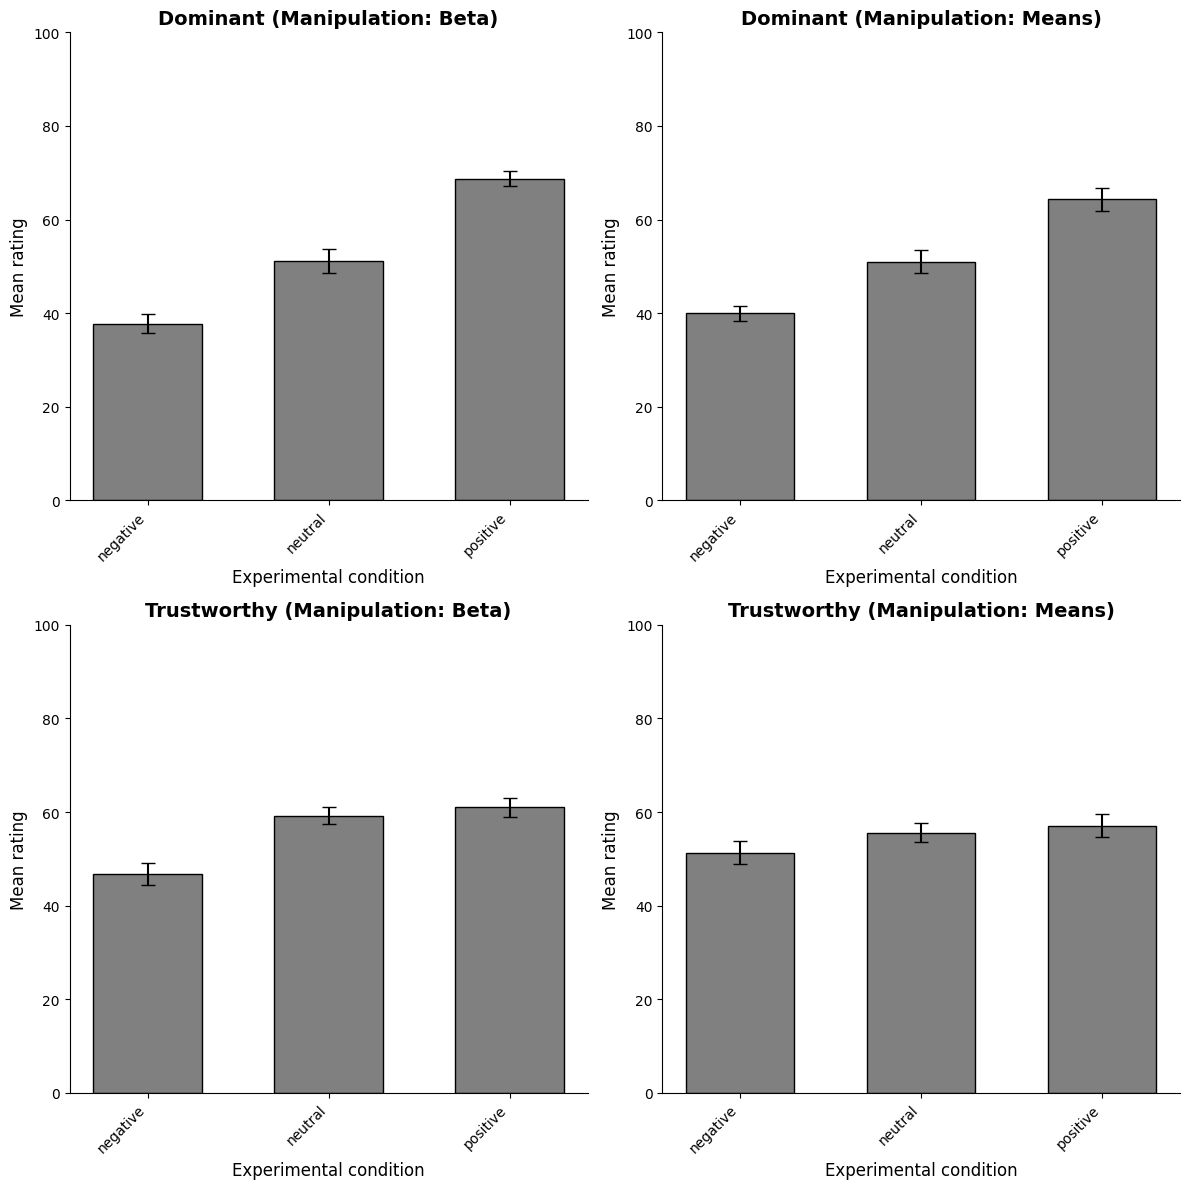

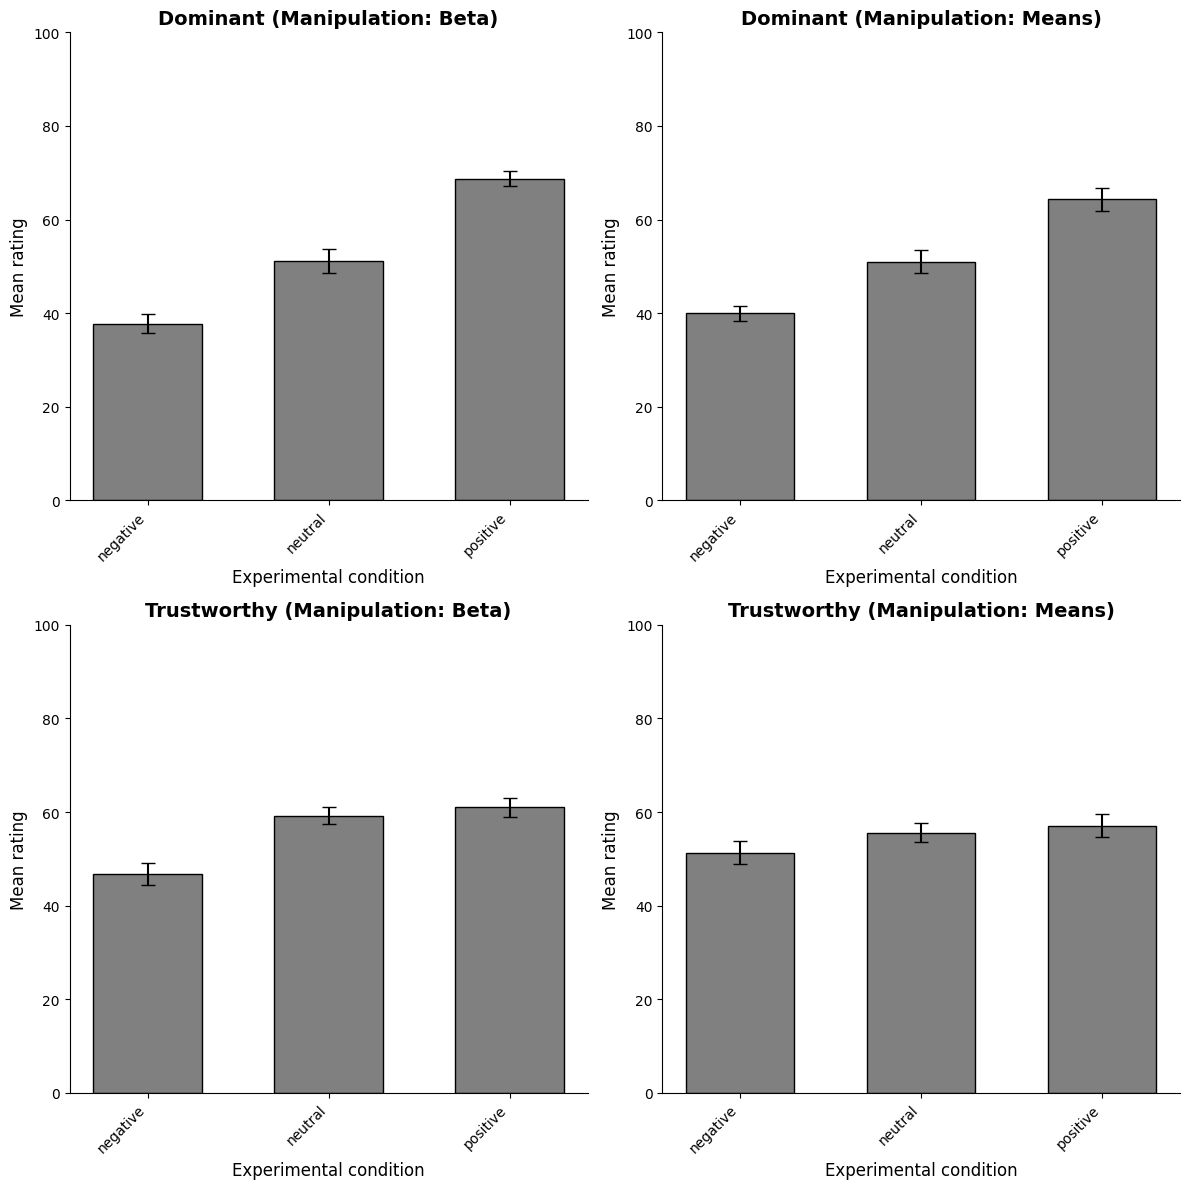

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary to map manipulation names to desired display names
manipulation_display_names = {
    "beta": "Beta",
    "means": "Means"
}

# Reshape merged_data to long format
df_long = pd.melt(
    merged_data,
    id_vars=['image', 'attribute', 'manipulation'],
    value_vars=['negative', 'neutral', 'positive'],
    var_name='experimental_condition',
    value_name='rating'
)

# Calculate mean, standard deviation, and count by attribute, condition, and manipulation
summary_df = df_long.groupby(['attribute', 'experimental_condition', 'manipulation']).agg(
    mean_rating=('rating', 'mean'),
    std_rating=('rating', 'std'),
    count=('rating', 'size')
).reset_index()

# Calculate SEM (standard error of the mean)
summary_df['sem'] = summary_df['std_rating'] / np.sqrt(summary_df['count'])

# Define experimental conditions
conditions = ['Decreased trait intensity', 'Neutral condition', 'Increased trait intensity']

# Function to plot each attribute with confidence intervals
def plot_with_confidence_intervals(attribute, manipulation, ax):
    # Filter data for the current attribute and manipulation
    subset = summary_df[(summary_df['attribute'] == attribute) & (summary_df['manipulation'] == manipulation)]

    # Get the display name for the manipulation
    manipulation_display = manipulation_display_names.get(manipulation, manipulation)

    # Get mean ratings and SEMs in the same order as 'conditions'
    mean_ratings = [subset[subset['experimental_condition'] == cond]['mean_rating'].values[0] if cond in subset['experimental_condition'].values else 0 for cond in conditions]
    sem_ratings = [subset[subset['experimental_condition'] == cond]['sem'].values[0] if cond in subset['experimental_condition'].values else 0 for cond in conditions]

    # Define positions for the bars
    bar_positions = np.arange(len(conditions))

    # Create the bar plot with error bars
    ax.bar(
        bar_positions,
        mean_ratings,
        yerr=sem_ratings,
        capsize=5,
        color='gray',
        edgecolor='black',
        ecolor='black',
        error_kw={'elinewidth': 1.5},
        width=0.6
    )

    # Set x-ticks and labels
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(conditions, rotation=45, ha='right')
    ax.set_ylim(0, 100)  # Adjust y-axis if needed

    # Set title with manipulation display name
    ax.set_title(f"{attribute.capitalize()} (Manipulation: {manipulation_display})", fontsize=14, weight='bold')
    ax.set_xlabel('Experimental condition', fontsize=12)
    ax.set_ylabel('Mean rating', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Get unique attributes and manipulations
attributes = summary_df['attribute'].unique()
manipulations = summary_df['manipulation'].unique()

# Create subplots for each attribute-manipulation combination
fig, axes = plt.subplots(nrows=len(attributes), ncols=len(manipulations), figsize=(6 * len(manipulations), 6 * len(attributes)), squeeze=False)

# Plot each attribute-manipulation combination
for i, attribute in enumerate(attributes):
    for j, manipulation in enumerate(manipulations):
        plot_with_confidence_intervals(attribute, manipulation, axes[i, j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("attribute_confidence_intervals_bars_with_custom_manipulation_names.png", dpi=300, bbox_inches='tight')
plt.show()


# Study 4

In [38]:
mturk["stop_disp"]

4      Nie
5      Nie
6      Nie
9      Nie
10     Nie
      ... 
378    Nie
380    Nie
381    Nie
382    Tak
383    Nie
Name: stop_disp, Length: 467, dtype: object

In [53]:
import pandas as pd
import numpy as np
mturk = pd.read_csv("v2_Twarze_+Flow+Matching+vs+Todorov_December+10,+2024_11.52.csv", low_memory=False).iloc[2:]
mturk = mturk.loc[mturk["stop_disp"]=="Nie"]


a = len(mturk)
short_time = 0
wrong_answer = 0
mturk = mturk[mturk["Duration (in seconds)"].apply(int)>900]
short_time+=a - len(mturk)
a = len(mturk)

mturk = mturk[[any([k in str(m).lower() for k in ["zauf","godn","atra","intel","gent"]]) for m in mturk["35_last_dim1 "]]]

mturk = mturk[[any([k in str(m).lower() for k in ["zauf","godn","atra","intel","gent"]]) for m in mturk["105_last_dim2"]]]
wrong_answer+=a - len(mturk)
mturk_new = mturk
mturk = pd.read_csv("Twarze_+Flow+Matching+vs+Todorov_November+30,+2024_21.32.csv", low_memory=False).iloc[2:]

mturk = mturk.loc[mturk["stop_disp"]=="Nie"]
mturk = mturk[mturk["Duration (in seconds)"].apply(int)>900]
short_time+=a - len(mturk)
a = len(mturk)
mturk = mturk[[any([k in str(m).lower() for k in ["zauf","godn","atra","intel","gent"]]) for m in mturk["last_dim"]]]
wrong_answer+=a - len(mturk)
mturk = pd.concat([mturk,mturk_new])
a = len(mturk)


print("Deleted due to faces stopped displaying, or short Duration: ",short_time)
print("Deleted due to incorrect text answer: ",wrong_answer)
k = lambda x: tuple(x.split(":")[0].replace(".png","").split("_"))
v = lambda x: float(x.split(":")[1] if x.split(":")[1]!="undefined" else -1)

import matplotlib.pyplot as plt
def get_ratings(mturk, conditions, includ_particip=False):
    ratings = []
    std = []
    j=0
    for i,r in enumerate(mturk["ratings_list"].to_list()):
      order = []
      for x in r.split(","):
        x = x.split(":")[0].replace(".png","")
        if x not in order and x:
          order+=[x]
      rating = [mturk.loc[:,c].iloc[i] for c in [m for m in mturk.columns if "_Q" in m]]
    
      r = [k(filename)+(str(k(filename)),float(impression)) for filename,impression in zip(order,rating)]
    
      if np.std([float(rr[-1]) for rr in r])<8:
        continue
      std+=[np.std([float(rr[-1]) for rr in r])]
      # print(len(set(rating)))
      if all([c(r, rating) for c in conditions]):
        ratings += [m[:-2]+(m[-2].replace("('",f"('{j}', '"),m[-1]) for m in r] if includ_particip else r
        j+=1
    return ratings

ratings = get_ratings(mturk, [lambda r, rating :len(set(rating))>0])
print("Unique answers: ",a - len(ratings)/120)
a = len(ratings)/120
mturk2_unfiltered = pd.DataFrame(ratings).iloc[:,-2:]
display(mturk2_unfiltered)
sd_unfiltered = mturk2_unfiltered.groupby(4).std()
means_unfiltered = mturk2_unfiltered.groupby(4).mean()


Deleted due to faces stopped displaying, or short Duration:  97
Deleted due to incorrect text answer:  93
Unique answers:  28.0


,4,5
0,"('15', 'smart', '0', 'our.jpg')",60.19
1,"('53', 'smart', '0', 'our.jpg')",0.00
2,"('60', 'smart', '3', 'our.jpg')",76.75
3,"('75', 'smart', '0', 'our.jpg')",20.06
4,"('162', 'smart', '1', 'our.jpg')",50.64
...,...,...
47635,"('52', 'smart', '4', 'our.jpg')",91.77
47636,"('82', 'smart', '2', 'our.jpg')",78.68
47637,"('88', 'smart', '3', 'our.jpg')",71.47
47638,"('36', 'smart', '1', 'our.jpg')",83.78


In [54]:

def deviation(row):
    return np.mean([(abs(means_unfiltered.loc[r[-2]]-r[-1])/sd_unfiltered.loc[r[-2]]) for r in row])
ratings_filtered = get_ratings(mturk, [lambda r, rating :len(set(rating))>60],False)
print("Deviation: ",a - len(ratings_filtered)/120)
a = len(ratings_filtered)/120
    
mturk2 = pd.DataFrame(ratings_filtered).iloc[:,-2:]
# sd = mturk2.groupby(4).std()
means = mturk2.groupby(4).mean().reset_index()


Deviation:  65.0


Wyniki dla trust


our.jpg


0    49.719640
1    53.383991
2    56.030472
3    57.876461
4    58.051137
dtype: float64

peterson.jpg


0    49.719640
1    53.962250
2    56.111020
3    57.915725
4    57.294765
dtype: float64

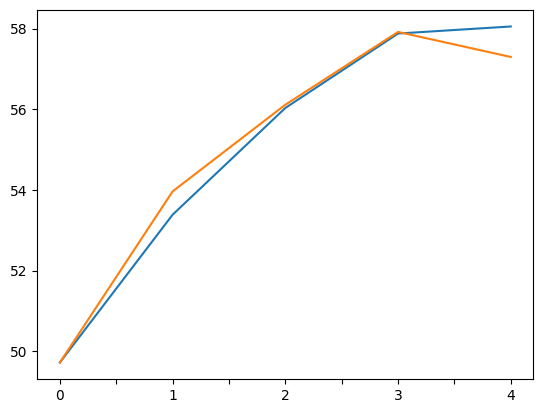

Wyniki dla attractive


our.jpg


0    42.894446
1    46.394958
2    49.513001
3    52.011806
4    52.701382
dtype: float64

peterson.jpg


0    42.894446
1    49.991919
2    54.826403
3    57.545188
4    57.283274
dtype: float64

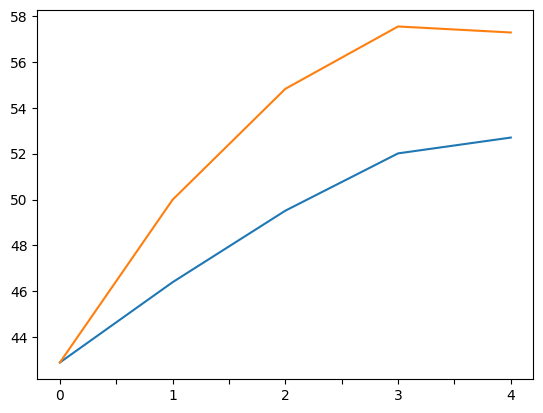

Wyniki dla smart


our.jpg


0    53.408778
1    58.247404
2    60.887576
3    63.636725
4    64.513643
dtype: float64

peterson.jpg


0    53.408778
1    55.881338
2    58.169838
3    59.767474
4    58.851609
dtype: float64

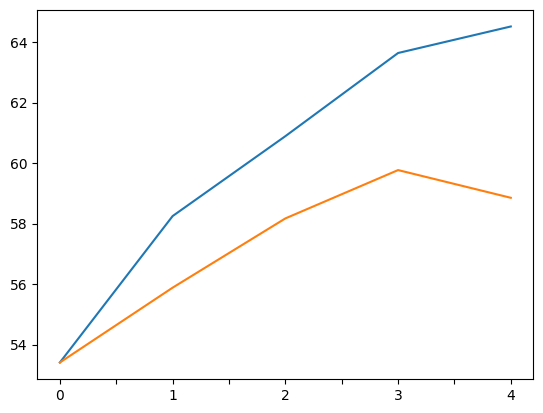

In [59]:
import pandas as pd
import ast

# Assuming the data is in a DataFrame called 'df'
# If it's not, you'll need to load it first
for dim_name in ["trust","attractive","smart"]:
    print(f"Wyniki dla {dim_name}\n\n")
    df_b = means.copy()
    df_b.columns = ['features', 'rating']
    df_b = df_b.loc[[dim_name in m for m in df_b.features]]
    df_b["features"] = ["'".join(m.split("'")[:3])+"'"+"'".join(m.split("'")[5:]) for m in df_b["features"]]
    # print(df_b.loc[["our" in m and "4" in m for m in df_b.features]].hist("rating"))

    # Step 1: Split the 'features' column into separate columns
    df_b[['image', 'value', 'manip']] = df_b['features'].apply(ast.literal_eval).tolist()

    # Step 2: Pivot the DataFrame to create columns for each 'value'
    df_b_pivot = df_b.pivot(index=['image', 'manip'], columns='value', values='rating')

    # Step 3: Reset the index to make 'image' and 'attribute' regular columns
    df_b_pivot.reset_index(inplace=True)

    # Step 4: Rename the columns for clarity
    df_b_pivot.columns.name = None
    # df_b_pivot.rename(columns={"-1": 'negative', "0.00": 'neutral', "1": 'positive'}, inplace=True)

    # Step 5: Sort the DataFrame by 'image' and 'attribute' for better readability
    df_b_pivot.sort_values(['image', 'manip'], inplace=True)
    for i in df_b_pivot.image.unique():
        df_b_pivot.loc[(df_b_pivot.image == i)&(df_b_pivot.manip=="peterson.jpg"),'0'] = df_b_pivot.loc[(df_b_pivot.image == i)&(df_b_pivot.manip=="our.jpg"),'0'].item()
    # Display the result
    for r in df_b_pivot.manip.unique():
        print(r)
        (df_b_pivot[df_b_pivot.manip == r].drop(["image","manip"], axis=1).mean()).plot()
        display(df_b_pivot[df_b_pivot.manip == r].drop(["image","manip"], axis=1).mean())
    plt.show()


# Additional Analysis

    id  name         dim manip_type  wzrost  spadek  parabola  flatline  \
0    0     1  attractive        our    True   False     False     False   
1    0     1  attractive   peterson   False   False      True      True   
2    1   113  attractive        our    True   False     False     False   
3    1   113  attractive   peterson    True   False     False     False   
4    2   115  attractive        our    True   False     False     False   
..  ..   ...         ...        ...     ...     ...       ...       ...   
75  37    87  attractive   peterson   False   False      True      True   
76  38    88  attractive        our    True   False     False     False   
77  38    88  attractive   peterson    True   False     False     False   
78  39     9  attractive        our   False   False      True      True   
79  39     9  attractive   peterson    True   False     False     False   

    flatline_coeff  chaos  max_effect_n_times_better  max_effect_better_by  \
0       183.606252  F

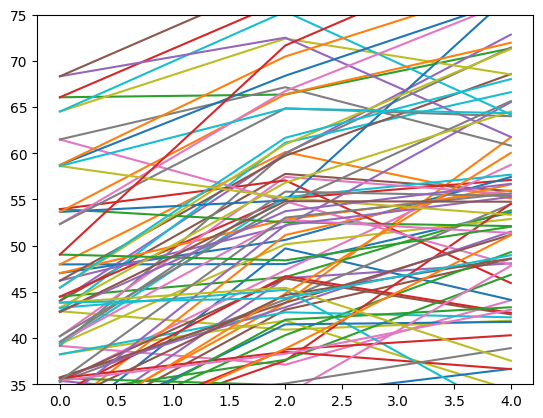

In [57]:
import pandas as pd
import ast

# Assuming the data is in a DataFrame called 'df'
# If it's not, you'll need to load it first
df_b = means.copy()
dim = "attractive"
df_b.columns = ['features', 'rating']
df_b = df_b.loc[[dim in m for m in df_b.features]]
df_b["features"] = ["'".join(m.split("'")[:3])+"'"+"'".join(m.split("'")[5:]) for m in df_b["features"]]
# print(df_b.loc[["our" in m and "4" in m for m in df_b.features]].hist("rating"))

# Step 1: Split the 'features' column into separate columns
df_b[['image', 'value', 'manip']] = df_b['features'].apply(ast.literal_eval).tolist()

# Step 2: Pivot the DataFrame to create columns for each 'value'
df_b_pivot = df_b.pivot(index=['image', 'manip'], columns='value', values='rating')

# Step 3: Reset the index to make 'image' and 'attribute' regular columns
df_b_pivot.reset_index(inplace=True)

# Step 4: Rename the columns for clarity
df_b_pivot.columns.name = None
# df_b_pivot.rename(columns={"-1": 'negative', "0.00": 'neutral', "1": 'positive'}, inplace=True)

# Step 5: Sort the DataFrame by 'image' and 'attribute' for better readability
df_b_pivot.sort_values(['image', 'manip'], inplace=True)
for i in df_b_pivot.image.unique():
    df_b_pivot.loc[(df_b_pivot.image == i)&(df_b_pivot.manip=="peterson.jpg"),'0'] = df_b_pivot.loc[(df_b_pivot.image == i)&(df_b_pivot.manip=="our.jpg"),'0'].item()
# Display the result
def convolution_on_list_of_numbers(l, filter):
    return [filter(l[i:i+5]) for i in range(len(l))]

filter = lambda l: sum(l[:3])/len(l[:3])
csv_entries = []
for ii, i in enumerate(df_b_pivot.image.unique()):
    for r in df_b_pivot.manip.unique():
        y = [df_b_pivot.loc[(df_b_pivot.image == i)&(df_b_pivot.manip==r),str(j)].item() for j in range(5)]
        y = [y[0],convolution_on_list_of_numbers(y,filter)[1],convolution_on_list_of_numbers(y,filter)[4]]
        a,b,c = y
        plt.plot([0,2,4],y)
        wzrost = a<b<c
        spadek = c<b<a
        parabola = b>c and b>a
        flatline = a<b and c-b<0.1*(b-a)
        flatline_coeff = (c-b)/(b-a)
        chaos = not wzrost and not parabola and not spadek 
        max_effect_comparison = c - a
        medium_effect_comparison = b-a
        max_effect_delta = c
        medium_effect_delta = b
        csv_entries+=[(ii, int(i), dim,r[:-4], wzrost, spadek, parabola, flatline, flatline_coeff, chaos, max_effect_comparison, max_effect_delta, medium_effect_comparison, medium_effect_delta)]
        # (df_b_pivot[df_b_pivot.manip == r].drop(["image","manip"], axis=1).mean()).plot()
        # display(df_b_pivot[df_b_pivot.manip == r].drop(["image","manip"], axis=1).mean())
    plt.ylim(35,75)
    # plt.show()
# df_b_pivot

df = pd.DataFrame(csv_entries, columns=["id", "name", "dim", "manip_type", "wzrost", "spadek", "parabola", "flatline", "flatline_coeff", "chaos", "max_effect_division", "max_effect_delta", "medium_effect_division", "medium_effect_delta"])
v = df.loc[df.manip_type== "peterson", ["max_effect_division", "medium_effect_division"]].values[:]
df.loc[df.manip_type== "peterson", ["max_effect_division", "medium_effect_division"]] /= df.loc[df.manip_type== "our", ["max_effect_division", "medium_effect_division"]].values
df.loc[df.manip_type== "our", ["max_effect_division", "medium_effect_division"]] /= v
v = df.loc[df.manip_type== "peterson", ["max_effect_delta", "medium_effect_delta"]].values[:]
df.loc[df.manip_type== "peterson", ["max_effect_delta", "medium_effect_delta"]] -= df.loc[df.manip_type== "our", ["max_effect_delta", "medium_effect_delta"]].values
df.loc[df.manip_type== "our", ["max_effect_delta", "medium_effect_delta"]] -= v
df.rename(columns={"max_effect_division": "max_effect_n_times_better", "medium_effect_division": "medium_effect_n_times_better", "max_effect_delta": "max_effect_better_by", "medium_effect_delta": "medium_effect_better_by"}, inplace=True)
print(df)
df.to_csv(dim+".csv")
# df.drop("dim", axis=1).groupby("manip_type").mean()

